In [11]:
import numpy as np 
from sklearn import datasets
import matplotlib.pyplot as plt
import os, sys
import networkx as nx

In [5]:
import kmapper as km
from kmapper.plotlyviz import *
import sklearn

import warnings
warnings.filterwarnings("ignore")

In [7]:
data_dir = '../data/corr-mats/TimeSeriesAAL/'

fs = os.listdir(data_dir)
ts_data = {}
subs = []
for f in fs:
    sub = f.split('_')[1]
    subs.append(sub)
    test = int(f.split('_')[3][-1]);
    if sub not in ts_data:
        ts_data[sub] = {}
    ts_data[sub][test] = np.loadtxt(data_dir+f)

In [8]:
kms = {}
for sub in subs:
    X = np.array(ts_data[sub][0])
    # Create another 2-D lens with UMAP
    mapper = km.KeplerMapper(verbose=0)
    import umap
    lens = mapper.fit_transform(X, projection=umap.UMAP(n_neighbors=15,
                                                        min_dist=0.3,
                                                        n_components=2,
                                                        metric='correlation',
                                                        random_state=3571))
    cover = km.Cover(n_cubes=15, perc_overlap=0.7)
    # Define the simplicial complex
    kms[sub] = mapper.map(lens,X,
                         
                          clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                           random_state=3471))



In [9]:
def mapper_weighting(g):
    import networkx as nx
    gg = g.copy();
    w = {}
    mem_dict = nx.get_node_attributes(g, 'membership')
    for edge in g.edges():
         w[edge] = len(set(mem_dict[edge[0]]).intersection(set(mem_dict[edge[1]])))
    nx.set_edge_attributes(gg,w,'weight');
    return gg;

In [12]:
gs = {}
wgs = {}
for sub in subs:
    gs[sub] = km.to_networkx(kms[sub]);
    wgs[sub] = mapper_weighting(gs[sub])
    wgs[sub] = nx.relabel_nodes(wgs[sub], dict(zip(wgs[sub].nodes(), range(wgs[sub].number_of_nodes()))))

In [13]:
def weight_based_filtration(g, min_weight=None):
    import networkx as nx 
    import dionysus as dio
    w = nx.get_edge_attributes(g,'weight');
    ww = [(k, w[k]) for k in sorted(w, key=w.get, reverse=True)]
    if min_weight==None:
        min_weight = ww[-1][1];
    gg = nx.Graph();
    gg.add_nodes_from(g.nodes());
    CD = dio.Filtration()
    index = 0
    for n in g.nodes():
        CD.append(dio.Simplex([n],index))

    for k, v in ww:
        gg.add_edge(k[0],k[1]);
        cliques = nx.find_cliques(gg);
        for clique in cliques:
            if len(clique)>3:
                new_simplices = dio.closure([dio.Simplex(clique)], len(clique));
                for simp in new_simplices:
                    if dio.Simplex(simp) not in CD:
                        CD.append(dio.Simplex(simp,index));
            elif len(clique)==2:
                CD.append(dio.Simplex(clique,index))
        index+=1; 
        if v==min_weight:
            break;
    return CD, index;
    

In [14]:
fils = {}
for sub in wgs:
    print(sub)
    fils[sub]= weight_based_filtration(wgs[sub],1);

211720
756055
857263
196750
199655
129028
198451
188347
123117
117122
149337
103111
161731
106016
110411
118730
201111
148335
100307
148840
151627
154734
159340
144832
135225
133019
136833
751348
280739
108828
123925
122317
212318
135932
138534
397760
122620
126325
151223
149741
103414
118932
116524
128632
672756
118528
101107
208226
156637
113619
131217
130013
113922
221319
103818
499566
176542
189450
190031
192540
792564
105115
111716
127630
133928
245333
139637
298051
162733
105014
149539
125525
214423
100408
101309
178950
140925
856766
239944
111312
153025
414229
366446
163129
128127
147737
127933
654754
130316
131722
160123
151526
211417
101915
899885
115320
146432
124422
114419
120111


In [15]:
import dionysus as dio
homs = {};
dgms = {}
for sub in fils:
    homs[sub] = dio.homology_persistence(fils[sub][0])
    dgms[sub] = dio.init_diagrams(homs[sub], fils[sub][0])
    
    

In [16]:
new_diag = {}


for sub in dgms:
    new_diag[sub] = {}
    dim = 0
    for dgm in dgms[sub]:
        new_diag[sub][dim] = []
        for el in dgm:
            new_el = [el.birth, el.death]
            if new_el[1] == np.inf:
                new_el[1] = fils[sub][1]
        new_diag[sub][dim].append(new_el);
        dim+=1


In [17]:
import persim

dim = 1
deh = np.zeros((len(dgms), len(dgms)));
for i, f in enumerate(dgms.keys()):
    for j, ff in enumerate(dgms.keys()):
        if len(new_diag[f])>=1 and len(new_diag[ff])>=1:
            deh[i,j] = persim.sliced_wasserstein(np.array(new_diag[f][dim]),np.array(new_diag[ff][dim]),10)


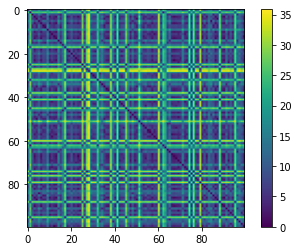

In [18]:
plt.imshow(deh)
plt.colorbar()

Populating the interactive namespace from numpy and matplotlib


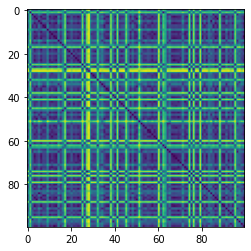

In [19]:
%pylab inline
import matplotlib.pyplot as plt
plt.imshow(deh)